# Generates a mock cluster's AGN and runs emcee to recover the model parameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
from astropy.cosmology import FlatLambdaCDM
from scipy import stats
import astropy.units as u
from time import time
import corner
import emcee
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [2]:
# Set our cosmology
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

# Set our random seed
np.random.seed(123)

## Functions needed for mock data generation

In [3]:
def model_rate(z, m, r_r500, params):
    """
    Our generating model.

    :param z: Redshift
    :param m: M_500
    :param r_r500: r / r_500
    :param params: Tuple of (theta, eta, zeta, beta)
    :return:
    """

    theta, eta, zeta, beta = params
    background = C_true

    theta = theta / u.Mpc**2
    background = background / u.arcmin**2

    # Our amplitude is determined from the cluster data
    a = theta * cosmo.kpc_proper_per_arcmin(z).to(u.Mpc/u.arcmin)**2 * (1 + z)**eta * (m / (1e15 * u.Msun))**zeta

    # For now, we assume no background contamination. All objects are in the cluster.
    model = a * (1 + (r_r500/0.1)**2)**(-1.5 * beta + 0.5) + background

    model[r_r500 > 5.] = 0.

    return model.value


def poisson_point_process(model, dx, dy=None):
    """
    Uses a spatial Poisson point process to generate AGN candidate coordinates.

    :param model: The model rate used in the Poisson distribution to determine the number of points being placed.
    :param dx: Upper bound on x-axis (lower bound is set to 0).
    :param dy: Upper bound on y-axis (lower bound is set to 0).
    :return coord: 2d numpy array of (x,y) coordinates of AGN candidates.
    """

    if dy is None:
        dy = dx

    # Draw from Poisson distribution to determine how many points we will place.
    p = stats.poisson(model * dx * dy).rvs()
    print('Number of points placed: ', p)

    # Drop `p` points with uniform x and y coordinates
    x = stats.uniform.rvs(0, dx, size=p)
    y = stats.uniform.rvs(0, dy, size=p)

    # Combine the x and y coordinates.
    coord = np.vstack((x, y))

    return coord


## Functions needed for MCMC fit

In [4]:
# Set our log-likelihood
def lnlike(param, catalog):

    ni = model_rate(catalog['REDSHIFT'][0], catalog['M500'][0]*u.Msun, catalog['r_r500'], param)

    rall = np.linspace(0, 5, 100)
    nall = model_rate(catalog['REDSHIFT'][0], catalog['M500'][0]*u.Msun, rall, param)

    # Use a spatial possion point-process log-likelihood
    total_lnlike = np.sum(np.log(ni * catalog['r_r500'])) - np.trapz(nall * 2*np.pi * rall, rall)

    return total_lnlike


# For our prior, we will choose uninformative priors for all our parameters and for the constant field value we will use
# a gaussian distribution set by the values obtained from the SDWFS data set.
def lnprior(param):
    # Extract our parameters
    theta, eta, zeta, beta = param

    # # Set our hyperparameters
    # h_C = 0.371
    # h_C_err = 0.157

    # Define all priors to be gaussian
    if 0. <= theta <= 10. and -3. <= eta <= 3. and -3. <= zeta <= 3. and -3. <= beta <= 3.:
        theta_lnprior = 0.0
        eta_lnprior = 0.0
        beta_lnprior = 0.0
        zeta_lnprior = 0.0
    else:
        theta_lnprior = -np.inf
        eta_lnprior = -np.inf
        beta_lnprior = -np.inf
        zeta_lnprior = -np.inf

    # C_lnprior = -0.5 * np.sum((C - h_C)**2 / h_C_err**2)

    # Assuming all parameters are independent the joint log-prior is
    total_lnprior = theta_lnprior + eta_lnprior + zeta_lnprior + beta_lnprior #+ C_lnprior

    return total_lnprior


# Define the log-posterior probability
def lnpost(param, catalog):
    lp = lnprior(param)

    # Check the finiteness of the prior.
    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike(param, catalog)

## Generate the mock data

In [5]:
# Set up grid of radial positions
r_dist = np.linspace(0, 6, 50)

# Draw mass and redshift distribution from a uniform distribution as well.
mass_dist = np.random.uniform(0.2e15, 1.8e15, 300)
z_dist = np.random.uniform(0.5, 1.7, 300)

# Create cluster names
name_bank = ['SPT_Mock_{:03d}'.format(i) for i in range(300)]
SPT_data = Table([name_bank, z_dist, mass_dist], names=['SPT_ID', 'REDSHIFT', 'M500'])

# We'll need the r500 radius for each cluster too.
SPT_data['r500'] = (3 * SPT_data['M500'] /
                    (4 * np.pi * 500 * cosmo.critical_density(SPT_data['REDSHIFT']).to(u.Msun / u.Mpc**3)))**(1/3)


#### Model parameters:

In [6]:
# Set parameter values
theta_true = 5.0     # Amplitude. To get realistic AGN counts per cluster (~3) this needs to be ~(5-2) x 10^-6.
eta_true = 1.2       # Redshift slope
beta_true = 0.5      # Radial slope
zeta_true = -1.0     # Mass slope
C_true = 0.371       # Background AGN surface density

params_true = (theta_true, eta_true, zeta_true, beta_true)

In [7]:
cluster = SPT_data[1]

spt_id = cluster['SPT_ID']
z_cl = cluster['REDSHIFT']
m500_cl = cluster['M500'] * u.Msun
r500_cl = cluster['r500'] * u.Mpc
print("---\nCluster Data: z = {z:.2f}, M500 = {m:.2e}, r500 = {r:.2f}".format(z=z_cl, m=m500_cl, r=r500_cl))

# Calculate the model values for the AGN candidates in the cluster
rad_model = model_rate(z_cl, m500_cl, r_dist, params_true)

# Find the maximum rate. This establishes that the number of AGN in the cluster is tied to the redshift and mass of
# the cluster.
max_rate = np.max(rad_model)
print('Max rate: {}'.format(max_rate))

# dx is set to 350 to mimic an IRAC image's width in pixels.
dx = 10.

# Simulate the AGN using the spatial Poisson point process.
agn_coords = poisson_point_process(max_rate, dx)

# Find the radius of each point placed scaled by the cluster's r500 radius
radii = (np.sqrt((agn_coords[0] - dx/2.)**2 + (agn_coords[1] - dx/2.)**2))
         # * (0.8627 * u.arcsec / cosmo.arcsec_per_kpc_proper(z_cl).to(u.arcsec / u.Mpc))) / r500_cl

# Filter the candidates through the model to establish the radial trend in the data.
rate_at_rad = model_rate(z_cl, m500_cl, radii, params_true)

# Our rejection rate is the model rate at the radius scaled by the maximum rate
prob_reject = rate_at_rad / max_rate
# print(radii[0:5])
# print(prob_reject[0:5])

# Draw a random number for each candidate
alpha = np.random.uniform(0, 1, len(rate_at_rad))

x_final = agn_coords[0][np.where(prob_reject >= alpha)]
y_final = agn_coords[1][np.where(prob_reject >= alpha)]
print('Number of points in final selection: {}'.format(len(x_final)))

# Calculate the radii of the final AGN scaled by the cluster's r500 radius
r_final = (np.sqrt((x_final - dx/2.)**2 + (y_final - dx/2.)**2))
           # * (0.8627 * u.arcsec / cosmo.arcsec_per_kpc_proper(z_cl).to(u.arcsec / u.Mpc))) / r500_cl

# Create a table of our output objects
AGN_list = Table([r_final], names=['r_r500'])
AGN_list['SPT_ID'] = spt_id
AGN_list['M500'] = m500_cl
AGN_list['REDSHIFT'] = z_cl

outAGN = AGN_list['SPT_ID', 'REDSHIFT', 'M500', 'r_r500']

---
Cluster Data: z = 1.37, M500 = 6.58e+14 solMass, r500 = 0.79 Mpc
Max rate: 5.817679027675309
Number of points placed:  596
Number of points in final selection: 104


### Plot of model rate

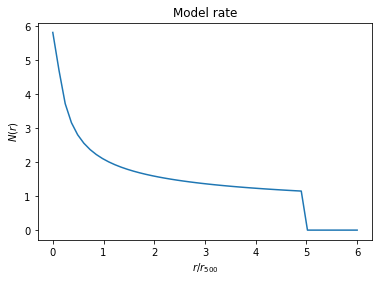

In [8]:
fig, ax = plt.subplots()
ax.plot(r_dist, rad_model)
ax.set(title='Model rate', xlabel=r'$r/r_{500}$', ylabel=r'$N(r)$')
plt.show()

### Plot of AGN candidates

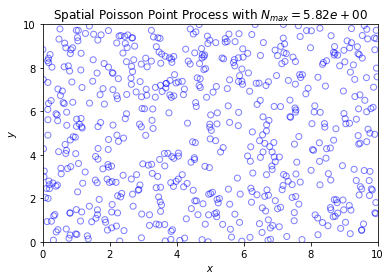

In [9]:
fig, ax = plt.subplots()
ax.scatter(agn_coords[0], agn_coords[1], edgecolor='b', facecolor='none', alpha=0.5)
ax.set(title=r'Spatial Poisson Point Process with $N_{{max}} = {:.2e}$'.format(max_rate),
       xlabel=r'$x$', ylabel=r'$y$', xlim=[0, dx], ylim=[0, dx])
plt.show()

### Plot of selected AGN

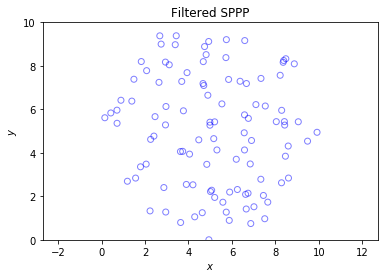

In [10]:
fig, ax = plt.subplots()
ax.scatter(x_final, y_final, edgecolor='b', facecolor='none', alpha=0.5)
ax.set_aspect('equal', 'datalim')
ax.set(title='Filtered SPPP', xlabel=r'$x$', ylabel=r'$y$', xlim=[0, dx], ylim=[0, dx])
plt.show()

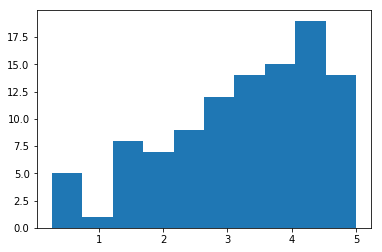

In [11]:
hist, bin_edges = np.histogram(r_final)
bins = (bin_edges[1:len(bin_edges)]-bin_edges[0:len(bin_edges)-1])/2. + bin_edges[0:len(bin_edges)-1]
plt.hist(r_final)

# but normalise the area
area_edges = np.pi * bin_edges**2
area = area_edges[1:len(area_edges)]-area_edges[0:len(area_edges)-1]

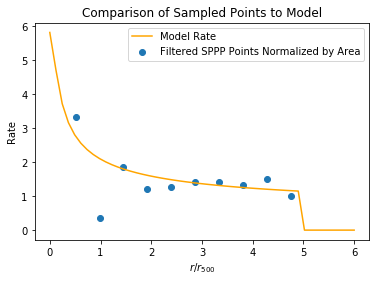

In [12]:
fig, ax = plt.subplots()
ax.scatter(bins, hist/area, label='Filtered SPPP Points Normalized by Area')
ax.plot(r_dist, rad_model, color="orange", label='Model Rate')
ax.set(
title='Comparison of Sampled Points to Model',
xlabel=r'$r/r_{500}$',
ylabel='Rate')
ax.legend()
fig.savefig('Data/MCMC/Mock_Catalog/Plots/binned_data_to_model.pdf', format='pdf')

## Fit the data to recover the model parameters using MCMC

In [13]:
# Typically this would be in another script so we'd be reading in the catalog from file.
mock_catalog = outAGN

In [14]:
# Set up our MCMC sampler.
# Set the number of dimensions for the parameter space and the number of walkers to use to explore the space.
ndim = 4
nwalkers = 200

# Also, set the number of steps to run the sampler for.
nsteps = 500

In [15]:
# We will initialize our walkers in a tight ball near the initial parameter values.
pos0 = emcee.utils.sample_ball(p0=[theta_true, eta_true, zeta_true, beta_true],
                               std=[1e-2, 1e-2, 1e-2, 1e-2], size=nwalkers)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=[mock_catalog], threads=1)

In [16]:
# Run the sampler.
start_sampler_time = time()
sampler.run_mcmc(pos0, nsteps)
print('Sampler runtime: {:.2f} s'.format(time() - start_sampler_time))

Sampler runtime: 192.34 s


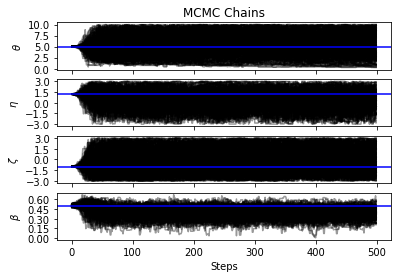

In [17]:
# Plot the chains
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax0.plot(sampler.chain[:, :, 0].T, color='k', alpha=0.4)
ax0.axhline(theta_true, color='b')
ax0.yaxis.set_major_locator(MaxNLocator(5))
ax0.set(ylabel=r'$\theta$', title='MCMC Chains')

ax1.plot(sampler.chain[:, :, 1].T, color='k', alpha=0.4)
ax1.axhline(eta_true, color='b')
ax1.yaxis.set_major_locator(MaxNLocator(5))
ax1.set(ylabel=r'$\eta$')

ax2.plot(sampler.chain[:, :, 2].T, color='k', alpha=0.4)
ax2.axhline(zeta_true, color='b')
ax2.yaxis.set_major_locator(MaxNLocator(5))
ax2.set(ylabel=r'$\zeta$')

ax3.plot(sampler.chain[:, :, 3].T, color='k', alpha=0.4)
ax3.axhline(beta_true, color='b')
ax3.yaxis.set_major_locator(MaxNLocator(5))
ax3.set(ylabel=r'$\beta$', xlabel='Steps')

plt.show()

In [18]:
# Remove the burnin, typically 1/3 number of steps
burnin = nsteps//3
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

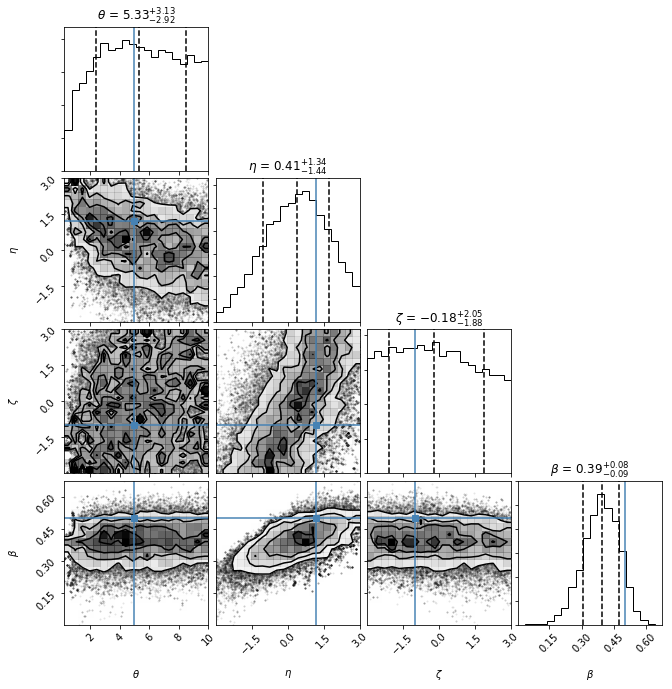

In [19]:
# Produce the corner plot
fig = corner.corner(samples, labels=[r'$\theta$', r'$\eta$', r'$\zeta$', r'$\beta$'],
                    truths=[theta_true, eta_true, zeta_true, beta_true],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True)

In [20]:
theta_mcmc, eta_mcmc, zeta_mcmc, beta_mcmc = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
                                                 zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("""MCMC Results:
theta = {theta[0]:.2f} +{theta[1]:.3f} -{theta[2]:.3f} (truth: {theta_true})
eta = {eta[0]:.2f} +{eta[1]:.3f} -{eta[2]:.3f} (truth: {eta_true})
zeta = {zeta[0]:.2f} +{zeta[1]:.3f} -{zeta[2]:.3f} (truth: {zeta_true})
beta = {beta[0]:.2f} +{beta[1]:.3f} -{beta[2]:.3f} (truth: {beta_true})"""
      .format(theta=theta_mcmc, eta=eta_mcmc,  zeta=zeta_mcmc, beta=beta_mcmc,
              theta_true=theta_true, eta_true=eta_true,  zeta_true=zeta_true, beta_true=beta_true))

print('Mean acceptance fraction: {}'.format(np.mean(sampler.acceptance_fraction)))

MCMC Results:
theta = 5.33 +3.131 -2.923 (truth: 5.0)
eta = 0.41 +1.336 -1.444 (truth: 1.2)
zeta = -0.18 +2.047 -1.881 (truth: -1.0)
beta = 0.39 +0.081 -0.086 (truth: 0.5)
Mean acceptance fraction: 0.46649
